## This code is to find out the different of each epoch and batch size combination

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Path

In [2]:
'''find the Model path'''
# find the current path
current_path = os.getcwd()
print('The current path is:', current_path)

# find the parent path
parent_path = Path(current_path).parent
print('The parent path is:', parent_path)

# find the data path
data_path = parent_path / 'Data/alexnet/fashion_mnist/'
print('The data path is:', data_path)

The current path is: /root/GreenAI/Cloud/4090/code
The parent path is: /root/GreenAI/Cloud/4090
The data path is: /root/GreenAI/Cloud/4090/Data/alexnet/fashion_mnist


### extract data

In [3]:
batch_sizes = [64, 128, 256, 512,1024,2048]
epochs = [10, 20, 30, 40, 50]
rounds = 3

#### read all the data from all the folders

In [4]:
folder_list = []
for epoch in epochs:
    for batch in batch_sizes:
        for round in range(rounds):
            folder_name = 'E' + str(epoch) + '_B' + str(batch) + '_R' + str(round)
            # print('The folder name is:', folder_name)
            folder_list.append(folder_name)
            
# find the folders in the data path
folder_names = os.listdir(data_path)
print('The folder names are:', folder_names)
print('The folder list is:', folder_list)

# find the common folders
common_folders = list(set(folder_list).intersection(folder_names))
# sort the common folders
common_folders.sort()
print('The common folders are:', common_folders)
print(len(common_folders))

The folder names are: ['E10_B64_R0', 'E10_B64_R1', 'E10_B64_R2', 'E10_B128_R0', 'E10_B128_R1', 'E10_B128_R2', 'E10_B256_R0', 'E10_B256_R1', 'E10_B256_R2', 'E10_B512_R0', 'E10_B512_R1', 'E10_B512_R2', 'E20_B64_R0', 'E20_B64_R1', 'E20_B64_R2', 'E20_B128_R0', 'E20_B128_R1', 'E20_B128_R2', 'E20_B256_R0', 'E20_B256_R1', 'E20_B256_R2', 'E20_B512_R0', 'E20_B512_R1', 'E20_B512_R2', 'E30_B64_R0', 'E30_B64_R1', 'E30_B64_R2', 'E30_B128_R0', 'E30_B128_R1', 'E30_B128_R2', 'E30_B256_R0', 'E30_B256_R1', 'E30_B256_R2', 'E30_B512_R0', 'E30_B512_R1', 'E30_B512_R2', 'E40_B64_R0', 'E40_B64_R1', 'E40_B64_R2', 'E40_B128_R0', 'E40_B128_R1', 'E40_B128_R2', 'E40_B256_R0', 'E40_B256_R1', 'E40_B256_R2', 'E40_B512_R0', 'E40_B512_R1', 'E40_B512_R2', 'E50_B64_R0', 'E50_B64_R1', 'E50_B64_R2', 'E50_B128_R0', 'E50_B128_R1', 'E50_B128_R2', 'E50_B256_R0', 'E50_B256_R1', 'E50_B256_R2', 'E50_B512_R0', 'E50_B512_R1', 'E50_B512_R2', 'E10_B1024_R0', 'E10_B2048_R0', 'E20_B1024_R0', 'E20_B2048_R0', 'E30_B1024_R0', 'E30_B2048_R

### analysis data

#### find the data in same epoch and batch size

In [5]:
name_dic = {
    'EpochEnergy': 'Epoch_energy',
    'EpochTime': 'Epoch_time',
    'TestAcc': 'Test_acc',
    'TrainAcc': 'Train_acc',
    'LayerTime': 'Layer_time',
    'TrainTime': 'Train_time',
    'TrainPartTime': 'Train_part_time'
}

In [6]:
# find the folders that have same epoch and batch size in common_folders
same_epoch_batch = []
for folder in common_folders:
    epoch = int(folder.split('_')[0][1:])
    batch = int(folder.split('_')[1][1:])
    same_epoch_batch.append((epoch, batch))
print('The same epoch and batch size are:', same_epoch_batch)

# find in each combination of epoch and batch size, find out the folder names
epoch_batch_folders = {}
for epoch, batch in same_epoch_batch:
    epoch_batch_folders[(epoch, batch)] = []
    for folder in common_folders:
        if int(folder.split('_')[0][1:]) == epoch and int(folder.split('_')[1][1:]) == batch:
            epoch_batch_folders[(epoch, batch)].append(folder)
print('The epoch and batch size folders are:', epoch_batch_folders)
# for each combination of epoch and batch size, find the average test accuracy, and the average energy consumption
avgenergy_acc = {}
energy_acc = {}
avgenergy_power = {}
avgpower_std = {}

for eb_comb in epoch_batch_folders:
    print('The epoch and batch size combination is:', eb_comb)
    # show the lenth of the values in the dictionary
    num_values = len(epoch_batch_folders[eb_comb])
    # print('The number of values in the dictionary is:', num_values)
    round_acc = np.zeros((num_values, 1))
    round_energy = np.zeros((num_values, 1))
    round_avgenergy = np.zeros((num_values, 1))
    powersec_round = np.zeros((num_values, 1))
    powerstd_epoch = np.zeros((num_values, 1))
    for folder in epoch_batch_folders[eb_comb]:
        files_path = data_path / folder
        files = os.listdir(files_path)
        # print('The files in the folder are:', files_path, files)
        test_acc = []
        epoch_energy = []
        powersec_epoch = []
        powerstd_epoch = []
        for f in files:
            name = f.split('.')[0]
            file_path = files_path / f
            if name in name_dic['TestAcc']:
                TestAcc = np.load(file_path, allow_pickle=True)
                test_acc.append(TestAcc[-1]) # get the last test accuracy
            elif name in name_dic['EpochEnergy']:
                EpochEnergy = np.load(file_path, allow_pickle=True)
                for energyrow in EpochEnergy:
                    # get the power consumption of each second in the epoch as well as the std of the power consumption
                    power_persec = np.mean(energyrow[0]) # get the avg power consumpt¡ion of each second in the epoch
                    power_std = np.std(energyrow[0]) # get the std of the power consumption of each second in the epoch
                    powersec_epoch.append(power_persec)
                    powerstd_epoch.append(power_std)
                    sum_row = np.sum(energyrow[0]) # sum the energy consumption of each epoch
                    epoch_energy.append(sum_row)
        # add to the round_acc and round_energy
        indexfolder = folder.split('_')[-1][1:]
        round_acc[int(indexfolder)] = np.mean(test_acc)
        powersec_round[int(indexfolder)] = np.mean(powersec_epoch)
        powerstd_epoch[int(indexfolder)] = np.mean(powerstd_epoch)
        round_avgenergy[int(indexfolder)] = np.mean(epoch_energy)  
        round_energy[int(indexfolder)] = np.sum(epoch_energy)
    # calculate the average test accuracy and energy consumption
    avg_acc = np.mean(round_acc)
    powersec = np.mean(powersec_round)
    powerstd = np.mean(powerstd_epoch)
    avg_avgenergy = np.mean(round_avgenergy)
    avg_energy = np.mean(round_energy)
    avg_acc = '{:.3f}'.format(avg_acc)
    powerstd = '{:.3f}'.format(powerstd)
    powersec = '{:.3f}'.format(powersec)
    avg_avgenergy = '{:.3f}'.format(avg_avgenergy)
    avg_energy = '{:.3f}'.format(avg_energy)
    print(f'The average test accuracy is: {avg_acc}')
    print(f'The average of average power consumption per second is: {powersec}')
    print(f'The average of average epoch energy consumption is: {avg_avgenergy}')
    print(f'The average of total energy consumption is: {avg_energy}')
    print(f'The average of power consumption std is: {powerstd}')
    # save the average test accuracy and energy consumption to the dictionary,
    # the key is the eb_comb, and the value is the average test accuracy and energy consumption\
    avgenergy_acc[eb_comb] = (avg_acc, avg_avgenergy)
    energy_acc[eb_comb] = (avg_acc, avg_energy)
    avgenergy_power[eb_comb] = (powersec, avg_avgenergy)
    avgpower_std[eb_comb] = (powersec, powerstd)

print('The energy consumption and accuracy are:', energy_acc)
print('The average energy consumption and accuracy are:', avgenergy_acc)
print('The power consumption per second is:', avgenergy_power)
print('The power consumption and std are:', avgpower_std)

The same epoch and batch size are: [(10, 1024), (10, 128), (10, 128), (10, 128), (10, 2048), (10, 256), (10, 256), (10, 256), (10, 512), (10, 512), (10, 512), (10, 64), (10, 64), (10, 64), (20, 1024), (20, 128), (20, 128), (20, 128), (20, 2048), (20, 256), (20, 256), (20, 256), (20, 512), (20, 512), (20, 512), (20, 64), (20, 64), (20, 64), (30, 1024), (30, 128), (30, 128), (30, 128), (30, 2048), (30, 256), (30, 256), (30, 256), (30, 512), (30, 512), (30, 512), (30, 64), (30, 64), (30, 64), (40, 1024), (40, 128), (40, 128), (40, 128), (40, 256), (40, 256), (40, 256), (40, 512), (40, 512), (40, 512), (40, 64), (40, 64), (40, 64), (50, 128), (50, 128), (50, 128), (50, 256), (50, 256), (50, 256), (50, 512), (50, 512), (50, 512), (50, 64), (50, 64), (50, 64)]
The epoch and batch size folders are: {(10, 1024): ['E10_B1024_R0'], (10, 128): ['E10_B128_R0', 'E10_B128_R1', 'E10_B128_R2'], (10, 2048): ['E10_B2048_R0'], (10, 256): ['E10_B256_R0', 'E10_B256_R1', 'E10_B256_R2'], (10, 512): ['E10_B51

### plot results

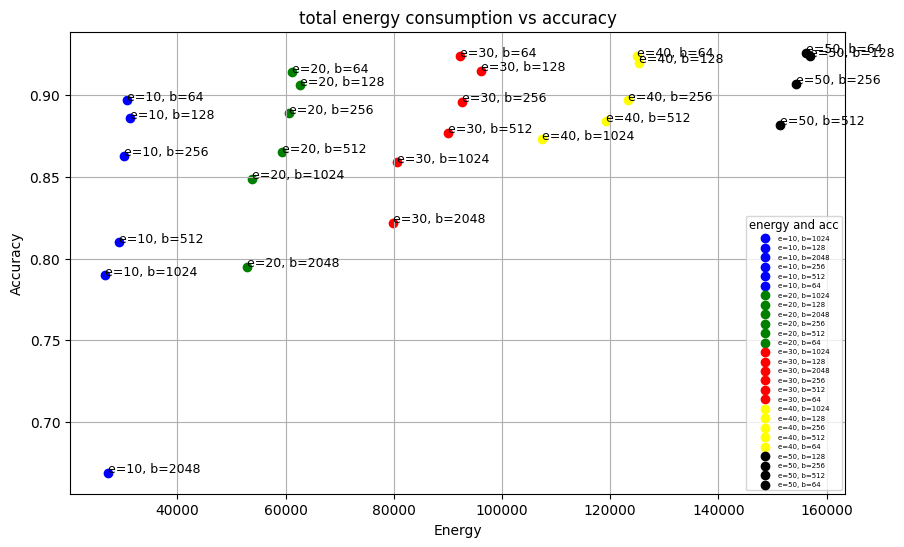

In [7]:
'''
The accuracy is the average of 5 rounds final test accuracy
The energy consumption is the average of 5 rounds total energy consumption
'''
# Prepare lists for plotting
energies = [float(values[1]) for values in energy_acc.values()]
accuracies = [float(values[0]) for values in energy_acc.values()]
labels = [f"e={key[0]}, b={key[1]}" for key in energy_acc.keys()]

# Extracting unique Param1 values and assigning colors
unique_param1 = np.unique([key[0] for key in energy_acc.keys()])
colors = ['blue', 'green', 'red', 'yellow', 'black']
color_map = dict(zip(unique_param1, colors))

# Prepare lists for plotting with colors
colors_for_plot = [color_map[key[0]] for key in energy_acc.keys()]

# Create scatter plot with colors
plt.figure(figsize=(10, 6))
for (energy, accuracy, label, color) in zip(energies, accuracies, labels, colors_for_plot):
    plt.scatter(energy, accuracy, color=color, label=label if label.split(',')[0] not in plt.gca().get_legend_handles_labels()[1] else "")
    plt.text(energy, accuracy, label, fontsize=9)

# Adding titles and labels
plt.title('total energy consumption vs accuracy')
plt.xlabel('Energy')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(title="energy and acc", loc='lower right', fontsize=5, title_fontsize='small')

# Show plot
plt.show()


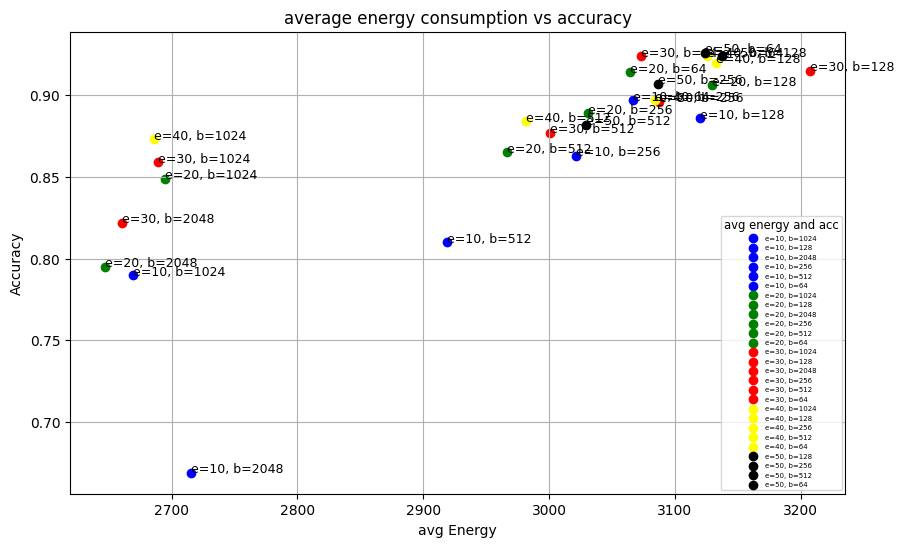

In [8]:
'''
The accuracy is the average of 5 rounds final test accuracy
The energy consumption is the average of 5 rounds total energy consumption
'''
# Prepare lists for plotting
energies = [float(values[1]) for values in avgenergy_acc.values()]
accuracies = [float(values[0]) for values in avgenergy_acc.values()]
labels = [f"e={key[0]}, b={key[1]}" for key in avgenergy_acc.keys()]

# Extracting unique Param1 values and assigning colors
unique_param1 = np.unique([key[0] for key in avgenergy_acc.keys()])
colors = ['blue', 'green', 'red', 'yellow', 'black']
color_map = dict(zip(unique_param1, colors))

# Prepare lists for plotting with colors
colors_for_plot = [color_map[key[0]] for key in avgenergy_acc.keys()]

# Create scatter plot with colors
plt.figure(figsize=(10, 6))
for (energy, accuracy, label, color) in zip(energies, accuracies, labels, colors_for_plot):
    plt.scatter(energy, accuracy, color=color, label=label if label.split(',')[0] not in plt.gca().get_legend_handles_labels()[1] else "")
    plt.text(energy, accuracy, label, fontsize=9)

# Adding titles and labels
plt.title('average energy consumption vs accuracy')
plt.xlabel('avg Energy')
plt.ylabel('Accuracy')
plt.grid(True)
# set the legend size
plt.legend(title="avg energy and acc", loc='lower right', fontsize=5, title_fontsize='small')

# Show plot
plt.show()


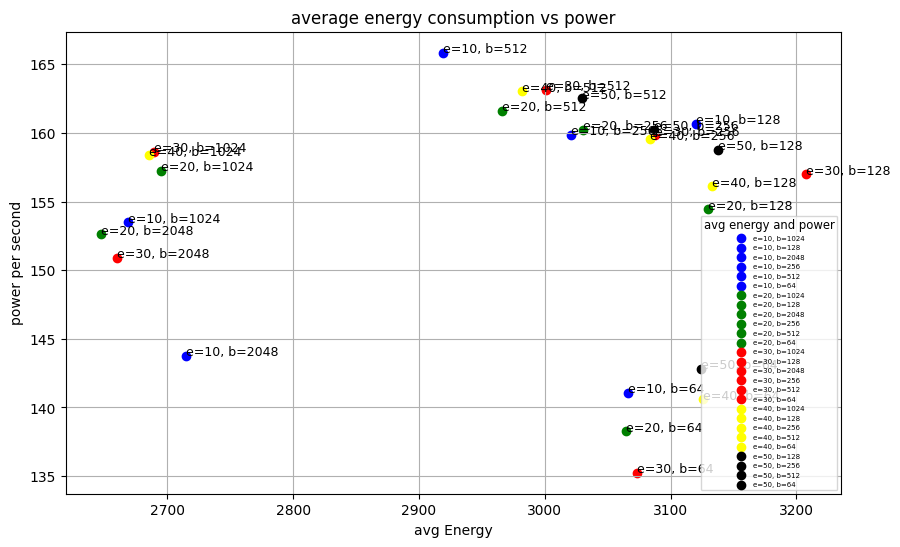

In [9]:
'''
The accuracy is the average of 5 rounds power consumption per second
The energy consumption is the average of 5 rounds total energy consumption
'''
# Prepare lists for plotting
energies = [float(values[1]) for values in avgenergy_power.values()]
accuracies = [float(values[0]) for values in avgenergy_power.values()]
labels = [f"e={key[0]}, b={key[1]}" for key in avgenergy_power.keys()]

# Extracting unique Param1 values and assigning colors
unique_param1 = np.unique([key[0] for key in avgenergy_power.keys()])
colors = ['blue', 'green', 'red', 'yellow', 'black']
color_map = dict(zip(unique_param1, colors))

# Prepare lists for plotting with colors
colors_for_plot = [color_map[key[0]] for key in avgenergy_power.keys()]

# Create scatter plot with colors
plt.figure(figsize=(10, 6))
for (energy, accuracy, label, color) in zip(energies, accuracies, labels, colors_for_plot):
    plt.scatter(energy, accuracy, color=color, label=label if label.split(',')[0] not in plt.gca().get_legend_handles_labels()[1] else "")
    plt.text(energy, accuracy, label, fontsize=9)

# Adding titles and labels
plt.title('average energy consumption vs power')
plt.xlabel('avg Energy')
plt.ylabel('power per second')
plt.grid(True)
plt.legend(title="avg energy and power", loc='lower right', fontsize=5, title_fontsize='small')

# Show plot
plt.show()


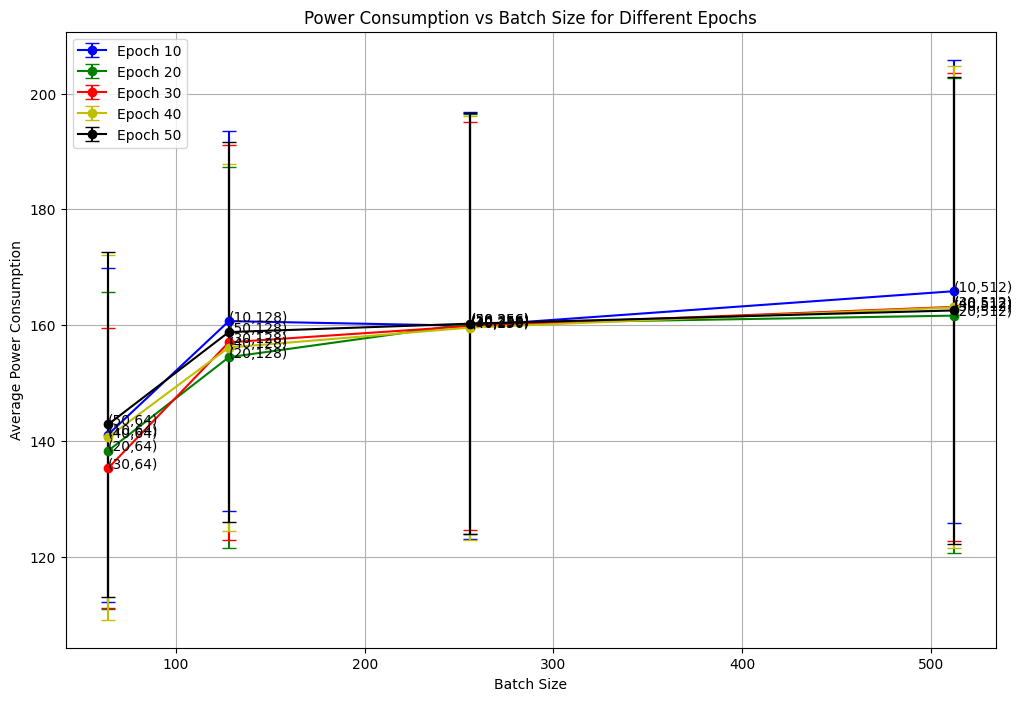

In [12]:
# Data dictionary
data = avgpower_std
# Extract unique epochs and batch sizes
epochs = sorted(set(e for e, _ in data.keys()))
batch_sizes = sorted(set(b for _, b in data.keys()))

# Colors and labels for different epochs
colors = ['b', 'g', 'r', 'y', 'black']  # Blue, Green, Red, Yellow, Purple for epochs 10, 20, 30
labels = ['Epoch 10', 'Epoch 20', 'Epoch 30', 'Epoch 40', 'Epoch 50']

# Create a figure
plt.figure(figsize=(12, 8))

# Plot data with annotations
for i, epoch in enumerate(epochs):
    x = []
    y = []
    yerr = []
    for batch_size in batch_sizes:
        avg_power, std_dev = data[(epoch, batch_size)]
        x.append(batch_size)
        y.append(float(avg_power))
        yerr.append(float(std_dev))
        
        # Annotate each data point
        plt.text(batch_size, float(avg_power), f'({epoch},{batch_size})')

    # Plot error bars and points
    plt.errorbar(x, y, yerr=yerr, fmt='o-', color=colors[i], capsize=5, label=labels[i])

# Set labels and title
plt.xlabel('Batch Size')
plt.ylabel('Average Power Consumption')
plt.title('Power Consumption vs Batch Size for Different Epochs')
plt.grid(True)
plt.legend()

# Display the plot
plt.show()